In [116]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pysptools
import pysptools.spectro as spectro
import pandas as pd
import openpyxl # must include as engine when opening .xlsx files in p3.6
from openpyxl.workbook import Workbook # find index of value closest to target value, in an array (e.g. feature wvl closest to a target wvl)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [305]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_spots.xlsx'
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
 
data = pd.read_excel(target_file, sheet_name = 'band_mean', header = None, index_col = None, engine='openpyxl') # choose sheet: 'band_mean', 'continuum', 'continuum_removed' !!! feature extraction requires raw spectra!!!!
#data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None, engine='openpyxl')
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None, engine='openpyxl')
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None, engine='openpyxl')

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

In [306]:
# modify FeaturesConvexHullQuotient functions from 'spectro' to include feature assymetry

class FeaturesConvexHullQuotient_hc(spectro.SpectrumConvexHullQuotient): # added by hc
    """
    Remove the convex-hull of the signal by hull quotient.
    Auto-extract the features and calculate their associated
    statistics. A baseline can be applied to avoid non-significant features.
    If you want to restrict the analysis to one continuum, just set the intervale
    with the startContinuum and stopContinuum parameters. It is up to you
    to ascertain that the continuum interval defined by startContinuum and
    stopContinuum do not cross the spectrum. The bilateral function can be use
    to remove small spectrum noises before extracting the features.

    Parameters:
        spectrum: `list`
            1D HSI data (p), a spectrum.

        wvl: `list`
            Wavelength of each band (p x 1).

        startContinuum: `float`
            The wavelength value of the starting left continuum.

        stopContinuum: `float`
            The wavelength value of the ending right continuum.

        baseline: `float`
            Features extracted above the baseline are rejected,
            features extracted below the baseline are kept.

    Reference:
        Kokaly F. Raymond, PRISM: Processing Routines in IDL for Spectroscopic
        Measurements (Installation Manual and User's Guide, Version 1.0),
        U.S. Geological Survey,Reston, Virginia: 2011.
    """

    def __init__(self, spectrum, wvl, startContinuum=None, stopContinuum=None, baseline=0, normalize=False):
        if startContinuum != None and stopContinuum != None:
            start = 0
            for i in range(len(wvl)):
                if wvl[i] > startContinuum:
                    start = i
                    break
            stop = 0
            for i in range(len(wvl)):
                if wvl[i] > stopContinuum:
                    stop = i
                    break
            spectrum = spectrum[start:stop]
            wvl = wvl[start:stop]
            
        spectro.SpectrumConvexHullQuotient.__init__(self, spectrum, wvl, normalize)
        self.base_line = baseline
        self.features = []
        self.features_all = []
        self._extract_features()
        self._base_line_clean()

    def _all_features_number(self):
        return len(self.hx)

    def _features_number(self):
        return len(self.features)

    def _extract_features(self):
        for feat_no in range(self._all_features_number() - 1):
            start1 = self.hx[feat_no]
            end1 = self.hx[feat_no + 1]
            for i in range(len(self.wvl)):
                if start1 == self.wvl[i]: start2 = i
                if end1 == self.wvl[i]:
                    end2 = i
                    break
            spectrum = self.spectrum[start2:end2+1]
            wvl = self.wvl[start2:end2+1]
            crs = self.crs[start2:end2+1]
            hx = self.hx[feat_no:feat_no+2]
            hy = self.hy[feat_no:feat_no+2]
            feat = {'seq': feat_no,
                    'id': None,
                    'state': None,
                    'spectrum': spectrum,
                    'wvl': wvl,
                    'crs': crs,
                    'hx': hx,
                    'hy': hy,
                    'cstart_wvl': None,
                    'cstop_wvl': None,
                    'abs_wvl': None,
                    'abs_depth': None,
                    'area': None,
                    'cslope': None,
                    'FWHM_x': None,
                    'FWHM_y': None,
                    'FWHM_delta': None,
                    'left_w': None, # added by hc
                    'right_w': None, # added by hc
                    'lr_asym': None # added by hc
                    }
            self.features_all.append(feat)

    def _area(self, y):
        from scipy.integrate import trapz
        # Before the integration:
        # flip the crs curve to x axis
        # and start at y=0
        yy = [abs(p-1) for p in y]
        deltax = self.wvl[1] - self.wvl[0]
        area = trapz(yy, dx=deltax)
        return area

    def _FWHM(self, feat):
        # full_width_at_half_maximum
        import numpy as np
        # get the middle curve value -> y
        depth = np.min(feat['crs'])
        y = depth + ((1 - depth) / 2)
        left_wvl = 0
        # curve_centre is x at the minimum of the curve
        curve_centre = feat['wvl'].index(feat['abs_wvl'])
        # going from the curve center to left
        for i in range(curve_centre,-1,-1):
            if feat['crs'][i] >= y:
                left_wvl = feat['wvl'][i]
                break
        stop = len(feat['wvl'])
        right_wvl = 0
        # going from the curve center to right
        for i in range(curve_centre, stop):
            if feat['crs'][i] >= y:
                right_wvl = feat['wvl'][i]
                break
        delta = right_wvl - left_wvl
        FWHM_x = (left_wvl, right_wvl)
        FWHM_y = (y, y)
        left_w = np.abs(left_wvl - curve_centre) # added by hc
        right_w = np.abs(right_wvl - curve_centre) # added by hc
        lr_asym = left_w/right_w # added by hc
        return FWHM_x, FWHM_y, delta, left_w, right_w, lr_asym # added by hc

    def _add_stats(self, feat):
        import numpy as np
        feat['area'] = self._area(feat['crs'])
        feat['cstart_wvl'] = feat['wvl'][0]
        feat['cstop_wvl'] = feat['wvl'][-1]
        feat['abs_wvl'] = feat['wvl'][np.argmin(feat['crs'])]
        feat['abs_depth'] = np.min(feat['crs'])
        feat['cslope'] = (feat['hy'][1] - feat['hy'][0]) / (feat['hx'][1] - feat['hx'][0])
        feat['FWHM_x'], feat['FWHM_y'], feat['FWHM_delta'],feat['left_w'],feat['right_w'],feat['lr_asym'] = self._FWHM(feat) # added by hc

    def _base_line_clean(self):
        id = 1
        for feat in self.features_all:
            if min(feat['crs']) < self.base_line:
                feat['state'] = 'keep'
                feat['id'] = id
                id += 1
                self._add_stats(feat)
                self.features.append(feat)
            else:
                feat['state'] = 'reject'

    def get_number_of_kept_features(self):
        """
        Returns: `int`
            The number of features that are kept (below the baseline).
            Only theses features have a statistic report.
        """
        return self._features_number()


    def get_continuum_removed_spectrum(self, feat_no):
        """
        Returns: `list`
            Feature spectrum with convex hull removed (p).
        """
        return self.features[feat_no-1]['crs']


    def get_absorbtion_wavelength(self, feat_no):
        """
        Returns: `float`
            The wavelength at the feature minimum.
        """
        return self.features[feat_no-1]['abs_wvl']


    def get_absorbtion_depth(self, feat_no):
        """
        Returns: `float`
            The absorbtion value at the feature minimum.
        """
        return self.features[feat_no-1]['abs_depth']


    def get_continuum_slope(self, feat_no):
        """
        Returns: `float`
            The feature continuum slope.
        """
        return self.features[feat_no-1]['cslope']


    def get_area(self, feat_no):
        """
        Returns: `float`
            The feature area.
        """
        return self.features[feat_no-1]['area']


    def get_continuum_start_wavelength(self, feat_no):
        """
        Returns: `float`
            The continuum left start wavelength value.
        """
        return self.features[feat_no-1]['cstart_wvl']


    def get_continuum_stop_wavelength(self, feat_no):
        """
        Returns: `float`
            The continuum right end wavelength value.
        """
        return self.features[feat_no-1]['cstop_wvl']


    def get_full_width_at_half_maximum(self, feat_no):
        """
        Returns: `float`
            Width at half maximum.
        """
        return self.features[feat_no-1]['FWHM_delta']


    def print_stats(self, feat_no):
        """Print a statistic summary for a kept feature.

            Parameters:
                feat_no: `int or 'all'`
                  The feature number, if feat_no='all', print
                  stats for all the kept features.
        """
        if feat_no == 'all':
            for i in range(len(self.features)):
                self._print_stats1(self.features[i])
        else:
            feat = self.features[feat_no-1]
            self._print_stats1(feat)


    def _print_stats1(self, feat):
        print('Feature Stats')
        print('  ---------------------------')
        print('  feature number:',feat['id'])
        print('  ---------------------------')
        print('  area:',feat['area'])
        print('  ---------------------------')
        print('  continuum start wavelength:',feat['cstart_wvl'])
        print('  continuum stop wavelength:',feat['cstop_wvl'])
        print('  continuum slope:',feat['cslope'])
        print('  ---------------------------')
        print('  center wavelength:',feat['abs_wvl'])
        print('  depth:',feat['abs_depth'])
        print('  ---------------------------')
        print('  full-width at half maximum:',feat['FWHM_delta'])
        print('  assymetry (left/right)',feat['lr_asym'])
        print()

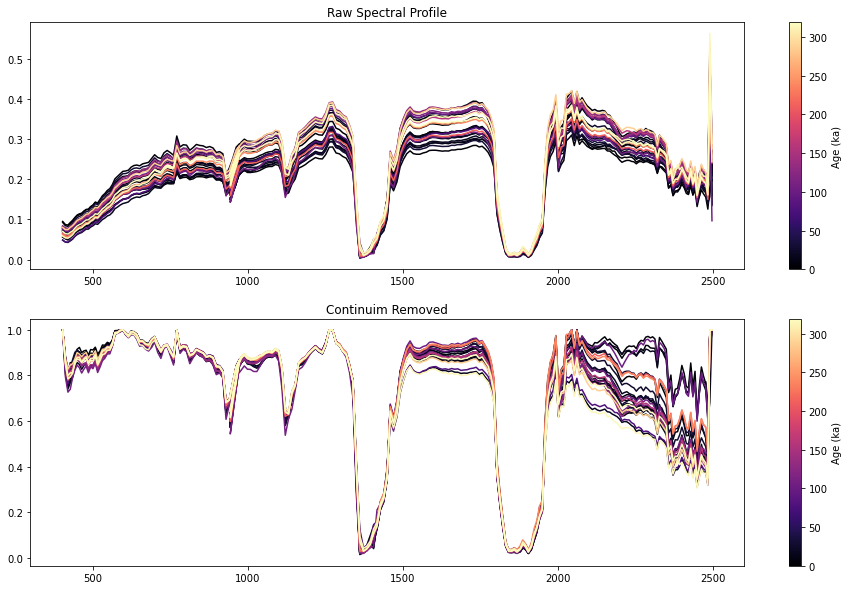

In [307]:
# remove continum for each spectral profile

data_list = data.values.tolist()
n = len(age)
data_crs = []

for i in range(n):
    crs = spectro.convex_hull_removal(data_list[i], nm_names)
    data_crs.append(crs)

y=np.array(data_crs, dtype = list)

# store values
crs = []
cx = []
cy = []

for i in range(n):
    crs_vals = y[i][0]
    cx_vals = y[i][1]
    cy_vals = y[i][2]
    
    crs.append(crs_vals)
    cx.append(cx_vals)
    cy.append(cy_vals)

#plot
plt.figure(figsize = (16,10))
plt.subplot(211)
for i in range(n):
    plt.plot(nm_names, data.iloc[i], label = age[i],  color=plt.cm.magma(norm(age[i])))
    plt.title('Raw Spectral Profile')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

# plot continum removed spectra
plt.subplot(212)
for i in range(n):
    plt.plot(nm_names, crs[i], label = age[i], color=plt.cm.magma(norm(age[i])))
    plt.title('Continuim Removed')
    plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

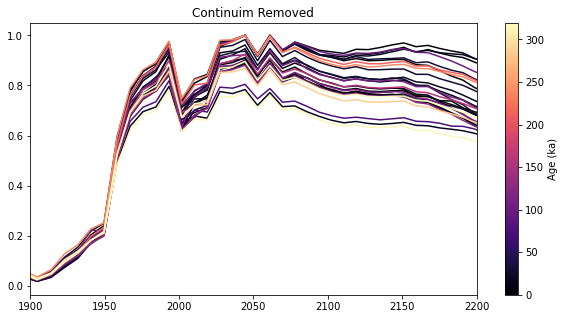

In [357]:
##### check features
plt.figure(figsize = (10,5))
for i in range(n):
    plt.plot(nm_names, crs[i], label = age[i], color=plt.cm.magma(norm(age[i])))
    plt.title('Continuim Removed')
    plt.xlim(1900,2200)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

(600.0, 2400.0)

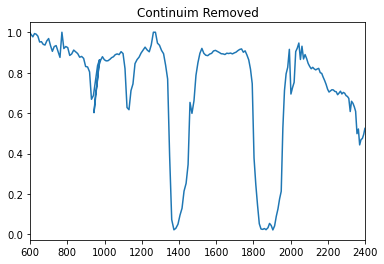

In [309]:
plt.plot(nm_names, crs[6])
plt.title('Continuim Removed')
plt.xlim(600,2400)

##### This method clips the dataset to the targeted range BEFORE identifying features. The benifit is that features can be identified in regions that may otherwised be too subtle when extracted from the full dataset. 
##### The drawabck is that feature statistics are different from when they are extracted using the entire spectrum (?), which is the standard method.

In [339]:
target_feat_df = pd.DataFrame()

In [360]:
# identify target feature, and 'search' range
#target_feat_list = [480, 700, 900, 1400, 1900, 2200, 2400]
# (480, 460, 500, 0.999), (900,850,1000),(1400),(1800), (1900,1825,2125,.999),(2200,2125,2300,0.999)
#(435,400,470,0.995),(900,800,1000)(700,650,800),(1400,1250,1525)(1900,1890,1990)(2000,1960,2045)

target_feat = 2000
wvl_min = 1960
wvl_max = 2045
baseline = 0.995 # 0 to 1


target_wvl_idx = np.where((np.array(nm_names) > wvl_min) & (np.array(nm_names) < wvl_max)) # choose range of feature search
idx_min = np.min(target_wvl_idx)
idx_max = np.max(target_wvl_idx)
data_target = data.loc[:,idx_min:idx_max]
data_target_list = data_target.values.tolist()
nm_names_target = list(nm_names[idx_min:idx_max])

target_feat_l = []
wvl_l = []
depth_l = []
area_l = []
lr_asym_l = []

n_spectrum = np.shape(data_target_list)[0]
for i in range(n_spectrum):
    print('-------- SPECTRUM ', i, ' --------')
    crs_features = FeaturesConvexHullQuotient_hc(data_target_list[i], nm_names_target, baseline=baseline, normalize=False)
    
    n_features = np.shape(crs_features.features)[0]
    for j in range(n_features):
        print('Feature ', j)
        print('   wavelength:', crs_features.features[j]['abs_wvl'])
        target_feat_l.append(target_feat)
        wvl_l.append(crs_features.features[j]['abs_wvl'])
        depth_l.append(1 - crs_features.features[j]['abs_depth'])
        area_l.append(crs_features.features[j]['area'])
        lr_asym_l.append(crs_features.features[j]['lr_asym'])


target_feat_df['wvl {}'.format(target_feat)] = wvl_l
target_feat_df['depth {}'.format(target_feat)] = depth_l
target_feat_df['area {}'.format(target_feat)] = area_l
target_feat_df['lr_asym {}'.format(target_feat)] = lr_asym_l

#target_feat_df = pd.DataFrame({ 'wvl {}'.format(target_feat): wvl_l,    # use if you want to reset the df each time
                               #'depth {}'.format(target_feat): depth_l,
                               #'area {}'.format(target_feat): area_l,
                               #'lr_asym {}'.format(target_feat): lr_asym_l})

-------- SPECTRUM  0  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  1  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  2  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  3  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  4  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  5  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  6  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  7  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  8  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  9  --------
Feature  0
   wavelength: 1984.5
Feature  1
   wavelength: 2001.8
-------- SPECTRUM  10  -------

ValueError: Length of values does not match length of index

In [361]:
target_feat_df

wvl 435  depth 435  area 435  lr_asym 435  wvl 700  depth 700  area 700  \
0     419.4   0.147715  4.381511     0.910621    760.1   0.138509  5.646110   
1     419.4   0.171420  5.012955     0.910621    760.1   0.105341  4.814891   
2     419.4   0.143412  4.532558     0.910621    760.1   0.129768  5.606490   
3     419.4   0.160980  4.724809     0.910621    760.1   0.137714  5.578402   
4     419.4   0.136012  4.081058     0.910621    760.1   0.121400  4.961039   
5     419.4   0.191528  5.212902     0.926209    760.1   0.125735  5.133288   
6     419.4   0.143087  4.391573     0.910621    760.1   0.121296  4.913534   
7     419.4   0.170819  5.032613     0.910621    760.1   0.140817  5.572754   
8     419.4   0.153980  4.821459     0.910621    760.1   0.112248  4.666512   
9     419.4   0.209149  6.535130     0.910621    760.1   0.116537  5.279023   
10    419.4   0.211169  6.023011     0.910621    760.1   0.121794  5.232890   
11    419.4   0.211729  6.420289     0.910621    760.1   0.140028  5.636969   
12    419.4   0.142552  4.450042     0.910621    760.1   0.116292  4.931765   
13    419.4   0.157795  4.672336     0.910621    760.1   0.129217  5.134358   
14    419.4   0.146712  4.101778     0.926209    760.1   0.140568  5.542327   
15    419.4   0.155177  4.862754     0.910621    760.1   0.132851  5.428163   
16    419.4   0.195540  5.957724     0.910621    760.1   0.104595  4.755276   
17    419.4   0.153538  4.583790     0.910621    760.1   0.125949  4.971132   
18    419.4   0.223210  6.747344     0.926209    760.1   0.149783  6.385896   
19    419.4   0.150627  4.507775     0.910621    760.1   0.122696  4.840929   
20    419.4   0.140108  4.261263     0.910621    760.1   0.123269  5.038457   
21    419.4   0.134863  4.161030     0.910621    760.1   0.110285  4.540307   
22    419.4   0.171362  5.104016     0.910621    760.1   0.126002  5.167869   
23    419.4   0.179007  5.532396     0.910621    760.1   0.120136  5.074403   
24    419.4   0.135569  4.257601     0.910621    760.1   0.117227  4.964250   
25    419.4   0.172971  5.574899     0.910621    760.1   0.115805  5.335670   
26    419.4   0.155910  5.079597     0.910621    760.1   0.114656  4.710116   

    lr_asym 700  wvl 1400  depth 1400   area 1400  lr_asym 1400  wvl 1900  \
0      0.959052    1360.8    0.984254  116.797156      0.917166    1904.6   
1      0.919026    1372.7    0.965894  111.774139      0.917109    1904.6   
2      0.959052    1360.8    0.982612  116.210398      0.917166    1904.6   
3      0.959052    1360.8    0.979950  115.669465      0.917166    1904.6   
4      0.959052    1372.7    0.976423  114.947437      0.917109    1904.6   
5      0.959052    1360.8    0.979763  113.293025      0.917166    1904.6   
6      0.959052    1372.7    0.975849  115.023909      0.917109    1904.6   
7      0.959052    1360.8    0.982164  116.032752      0.917166    1904.6   
8      0.959052    1372.7    0.971873  113.829588      0.917109    1904.6   
9      0.919026    1372.7    0.960452  111.149908      0.917109    1904.6   
10     0.959052    1360.8    0.973394  113.668655      0.917166    1904.6   
11     0.959052    1360.8    0.979594  115.043161      0.917166    1904.6   
12     0.959052    1372.7    0.972538  113.970941      0.917109    1904.6   
13     0.959052    1360.8    0.983592  116.024558      0.917166    1904.6   
14     0.959052    1360.8    0.982056  116.464937      0.917166    1904.6   
15     0.959052    1360.8    0.986140  117.703106      0.917166    1904.6   
16     0.959052    1372.7    0.951831  109.429877      0.917109    1904.6   
17     0.959052    1372.7    0.977910  115.421872      0.917109    1904.6   
18     0.959052    1360.8    0.980511  118.193784      0.917166    1904.6   
19     0.959052    1372.7    0.979003  115.225227      0.917109    1904.6   
20     0.959052    1372.7    0.978273  115.224840      0.917109    1904.6   
21     0.959052    1372.7    0.968981  112.861866      0.917109    1904.6   
22     0.959052    1

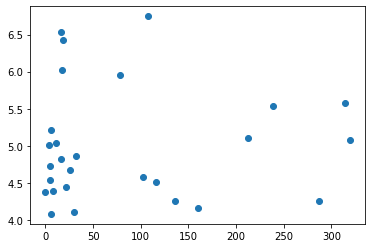

In [371]:
plt.scatter(age,target_feat_df['area 435'])

In [362]:
# save dataframe
#target_feat_df.to_csv('PRISMA_features.csv')

##### This method autmatically identifying all features first, and then extracts the statistics of the feature closest to the target wavelength. The beneifit is that it is a simplier approach, and more standard for publishing.
##### The drawaback is that manual quality control is required, since feature statisitcs of the nearest feature will always be recorded, but may not be the targeted feature (e.g. if no feature actually exsits near that wavelength). 

In [318]:
target_feat_full_spec = pd.DataFrame()

In [319]:
# Identify features (semi-automatically) for all spectrum in a dataset. Then extract chosen statistics from the feature CLOSEST to the target feature wavelength
# This WILL require some maniual control after the new dataset is created, specifically when no actual feature exsits near the target wavelength. Here, the closest feature will be used to export data into the dataframe.
target_feat_list = [480, 700, 900, 1400, 1900, 2200, 2400] # *manual* choose target feature wavelengths
baseline = 0.998 # *manual* choose baseline to extract features which fall below value, 0 to 1 

data_list = data.values.tolist()
nm_names_list = list(nm_names)
iteration = 0 

for wavelength in target_feat_list:
    iteration = iteration + 1
    target_feat = wavelength
    target_feat_l = []
    wvl_l = []
    depth_l = []
    area_l = []
    lr_asym_l = []

    n_spectrum = np.shape(data_list)[0]
    for i in range(n_spectrum):
        crs_features = FeaturesConvexHullQuotient_hc(data_list[i], nm_names_list, baseline=baseline, normalize=False)
        n_features = np.shape(crs_features.features)[0]

        abs_wvl_l = [crs_features.features[z]['abs_wvl'] for z in range(n_features)]
        target_feat_wvl = find_nearest(abs_wvl_l, target_feat)
        feature_idx = int(np.where([crs_features.features[z]['abs_wvl'] == target_feat_wvl for z in range(n_features)])[0]) #index where feature wavelength == chosen wavelength

        target_feat_l.append(target_feat)
        wvl_l.append(crs_features.features[feature_idx]['abs_wvl'])
        depth_l.append(1 - crs_features.features[feature_idx]['abs_depth'])
        area_l.append(crs_features.features[feature_idx]['area'])
        lr_asym_l.append(crs_features.features[feature_idx]['lr_asym'])
        
        if iteration == 1:
            print('SPECTRUM ', i, ' --------------')
            print('   n features: ', n_features)
            print('   wavelengths: ', abs_wvl_l)

    target_feat_full_spec['wvl {}'.format(target_feat)] = wvl_l
    target_feat_full_spec['depth {}'.format(target_feat)] = depth_l
    target_feat_full_spec['area {}'.format(target_feat)] = area_l
    target_feat_full_spec['lr_asym {}'.format(target_feat)] = lr_asym_l

#target_feat_df = pd.DataFrame({ 'wvl {}'.format(target_feat): wvl_l,    # use if you want to reset the df each time
                               #'depth {}'.format(target_feat): depth_l,
                               #'area {}'.format(target_feat): area_l,
                               #'lr_asym {}'.format(target_feat): lr_asym_l})

SPECTRUM  0  --------------
   n features:  5
   wavelengths:  [419.4, 760.1, 943.0, 1360.8, 2448.9]
SPECTRUM  1  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 1131.1, 1850.3]
SPECTRUM  2  --------------
   n features:  6
   wavelengths:  [419.4, 760.1, 943.0, 1360.8, 2052.8, 2483.6]
SPECTRUM  3  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 943.0, 1360.8]
SPECTRUM  4  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 943.0, 1904.6]
SPECTRUM  5  --------------
   n features:  6
   wavelengths:  [419.4, 760.1, 943.0, 1360.8, 2052.8, 2448.9]
SPECTRUM  6  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 943.0, 1904.6]
SPECTRUM  7  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 943.0, 1360.8]
SPECTRUM  8  --------------
   n features:  4
   wavelengths:  [419.4, 760.1, 943.0, 1904.6]
SPECTRUM  9  --------------
   n features:  3
   wavelengths:  [419.4, 943.0, 1904.6]
SPECTRUM  10  --------------
   n fe

In [320]:
target_feat_full_spec

wvl 480  depth 480   area 480  lr_asym 480  wvl 700  depth 700   area 700  \
0     419.4   0.179004  19.473069     0.791774    760.1   0.142224   9.458516   
1     419.4   0.197107  18.118586     0.895749    760.1   0.108238   7.595004   
2     419.4   0.176170  20.926482     0.757329    760.1   0.133226   9.159678   
3     419.4   0.201648  23.998168     0.757329    760.1   0.141115   9.079495   
4     419.4   0.175296  23.315877     0.735354    760.1   0.124857   8.433892   
5     419.4   0.222645  20.277577     0.895749    760.1   0.128819   8.081518   
6     419.4   0.183772  22.863922     0.735354    760.1   0.124320   7.820859   
7     419.4   0.208738  23.272893     0.895749    760.1   0.144234   9.115579   
8     419.4   0.191282  22.262038     0.757329    760.1   0.115066   7.327245   
9     419.4   0.248136  33.053437     0.895749    943.0   0.377163  67.089144   
10    419.4   0.249490  23.791497     0.895749    760.1   0.125048   8.552244   
11    419.4   0.259248  29.405340     0.757329    760.1   0.143563   9.374399   
12    419.4   0.181039  22.605372     0.735354    760.1   0.119360   7.902740   
13    419.4   0.197095  23.633293     0.735354    760.1   0.132323   8.188753   
14    419.4   0.180074  20.550638     0.895749    760.1   0.144073   9.209821   
15    419.4   0.193490  24.163247     0.735354    760.1   0.136849   9.605267   
16    419.4   0.236112  23.480509     0.895749    760.1   0.108215   8.477119   
17    419.4   0.199264  27.158758     0.735354    760.1   0.129286   8.338826   
18    419.4   0.273093  31.748229     0.757329    760.1   0.153977  10.978422   
19    419.4   0.196912  27.469533     0.735354    760.1   0.126039   8.263337   
20    419.4   0.185870  26.101161     0.735354    760.1   0.126575   8.384431   
21    419.4   0.173876  22.747485     0.735354    760.1   0.113323   7.493422   
22    419.4   0.212589  25.149677     0.735354    760.1   0.129248   8.445160   
23    419.4   0.219674  24.246031     0.791774    760.1   0.123187   8.170426   
24    419.4   0.171666  20.644084     0.757329    760.1   0.120139   7.814393   
25    419.4   0.213413  24.107103     0.791774    760.1   0.119627   9.461172   
26    419.4   0.199766  25.257766     0.735354    760.1   0.117665   7.703412   

    lr_asym 700  wvl 900  depth 900  ...   area 1900  lr_asym 1900  wvl 2200  \
0      0.958726    943.0   0.407244  ...  268.831346      0.917109    2448.9   
1      0.905242    760.1   0.108238  ...  469.999346      0.913425    1850.3   
2      0.905242    943.0   0.412676  ...    0.730188      0.991894    2052.8   
3      0.958726    943.0   0.415948  ...  494.766533      0.917109    1360.8   
4      0.905242    943.0   0.391363  ...  485.717288      0.908981    1904.6   
5      0.905242    943.0   0.405124  ...    0.693237      0.991894    2052.8   
6      0.905242    943.0   0.397870  ...  455.840617      0.913151    1904.6   
7      0.958726    943.0   0.426324  ...  476.968369      0.917109    1360.8   
8      0.905242    943.0   0.397855  ...  444.454815      0.913151    1904.6   
9      1.003371    943.0   0.377163  ...  549.916029      0.908933    1904.6   
10     0.905242    943.0   0.405057  ...    0.663158      0.991894    2052.8   
11     0.958726    943.0   0.425561  ...  492.929681      0.917109    1360.8   
12     0.905242    943.0   0.385901  ...  489.647269      0.908981    1904.6   
13     0.958726    943.0   0.411643  ...  425.707692      0.917109    1360.8   
14     0.958726    943.0   0.429470  ...  453.000881      0.917109    1360.8   
15     0.958726    943.0   0.412714  ...  271.229394      0.917109    2483.6   
16     0.905242    943.0   0.366759  ...  537.075185      0.908981    1904.6   
17     0.958726    943.0   0.395458  ...    0.724778      0.991894    2052.8   
18     0.958726    760.1   0.153977  ...  455.176435      0.917109    1360.8   
19     0.905242    943.0   0.399507  ...  481.934692      0.909172    1868.0   
20     0.905242    943.0   0.394097  ...  493.786678   

In [304]:
#log(0) # stop, check file overwrite

outputs = r'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' # output location

# save as single .xlsx with multiple sheets
with pd.ExcelWriter(outputs + sensor + '_spots.xlsx', mode = 'a') as writer:  # ! Make sure mode = append !
    target_feat_full_spec.to_excel(writer, sheet_name='features', header = True, index = False)

(0.35, 0.44)

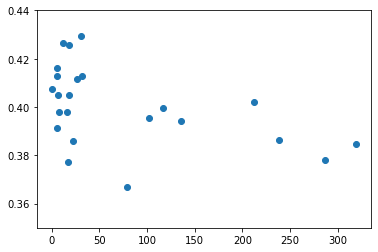

In [332]:
plt.scatter(age, target_feat_full_spec['depth 900'])
plt.ylim(0.35,0.44)